<h1> Amazon Apparel Recommendations </h1>



## Overview of the data

In [63]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

In [64]:
# reading json file
data = pd.read_json('tops_fashion.json')
print (data)

              asin author                         availability  \
0       B016I2TS4W   None                                 None   
1       B01N49AI08   None                                 None   
2       B01JDPCOHO   None                                 None   
3       B01N19U5H5   None                                 None   
4       B004GSI2OS   None  Usually ships in 6-10 business days   
5       B00TAEHGGS   None                                 None   
6       B012YX2ZPI   None   Usually ships in 4-5 business days   
7       B074GPTP3J   None                                 None   
8       B06Y2LCC5S   None                                 None   
9       B00T9W4E66   None                                 None   
10      B073Y91FTS   None                                 None   
11      B001LOUGE4   None                                 None   
12      B0751PWCP7   None                                 None   
13      B0747M995P   None                                 None   
14      B0

In [3]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])

Number of data points :  183137 Number of features: 19


In [4]:
data.columns

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

In [5]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()

Number of data points :  183137 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


#### Basic stats for the feature: product_type_name

In [7]:
print(data['product_type_name'].describe())

count     183137
unique        72
top        SHIRT
freq      167793
Name: product_type_name, dtype: object


In [8]:
# names of product_type
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [9]:
# 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167793),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

 #### Basic stats for the feature: brand

In [10]:
print(data['brand'].describe())

count     182986
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [11]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

#### Basic stats for the feature: color

In [12]:
print(data['color'].describe())

count     64955
unique     7380
top       Black
freq      13206
Name: color, dtype: object


In [13]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13206),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [14]:
 
print(data['formatted_price'].describe())

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [15]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154742),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [16]:
print(data['title'].describe())

count                                                183137
unique                                               175984
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [17]:
data.to_pickle('pickels/180k_apparel_data')

In [18]:
 #removing row's which have null values price
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [19]:
# remove row's which have null values color
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


#### number of data points are reduced from 183K  to 28K.


In [20]:
data.to_pickle('pickels/28k_apparel_data')

#### Remove near duplicate items

Understand about duplicates.

In [21]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

# find number of products that have duplicate titles but different color or some other feature.
print(sum(data.duplicated('title')))


2325


Remove duplicates : Part 1

In [22]:
data = pd.read_pickle('pickels/28k_apparel_data')

In [23]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [24]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [25]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61972,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133819,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81460,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75994,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151569,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [26]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [27]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    a = data['title'].loc[indices[i]].split()

    j = i+1
    while j < num_data_points:

        b = data['title'].loc[indices[j]].split()

        length = max(len(a), len(b))

        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        if (length - count) > 2:
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [28]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### We removed  the dupliactes which differ only at the end.

In [29]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [30]:
data.to_pickle('pickels/17k_apperal_data')

Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [31]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [32]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.
"""
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)
            
        data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
            """

"\nindices = []\nfor i,row in data.iterrows():\n    indices.append(i)\n\nstage2_dedupe_asins = []\nwhile len(indices)!=0:\n    i = indices.pop()\n    stage2_dedupe_asins.append(data['asin'].loc[i])\n    # consider the first apperal's title\n    a = data['title'].loc[i].split()\n    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']\n    for j in indices:\n        \n        b = data['title'].loc[j].split()\n        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']\n        \n        length = max(len(a),len(b))\n        \n        # count is used to store the number of words that are matched in both strings\n        count  = 0\n\n        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings\n        # example: a =['a', 'b', 'c', 'd']\n        # b = ['a', '

In [33]:
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  17593


In [34]:
data.to_pickle('pickels/16k_apperal_data')

Text pre-processing

In [35]:
data = pd.read_pickle('pickels/16k_apperal_data')

In [36]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'shouldn', 'or', "shouldn't", "she's", 'so', 'before', 'where', "aren't", 'm', 'which', "mightn't", 'with', 'against', 'a', 'when', 'if', 'some', 'very', 'shan', 'too', 'an', 't', 'why', 'through', 'our', "it's", 'after', 'no', 's', 'out', 'as', 'you', 'here', 'mightn', 'doing', "you're", "you've", "you'll", 'then', 'we', 'was', 'between', 'off', 'been', 'them', 'until', 'further', 'for', "wouldn't", 'who', 'and', "that'll", 'am', 'this', 'don', 'below', 'hasn', 'yourselves', 'ma', 'only', 'its', "shan't", 'of', 'should', "don't", 'while', 're', 'hers', 'are', 'above', 'just', 'during', 'on', "didn't", 'needn', "needn't", 'but', 'up', 'into', 'can', 'now', 'me', 'more', 'isn', 'is', 'not', 'by', 'did', 've', 'it', "couldn't", 'same', "hasn't", 'have', 'yourself', 'own', 'hadn', 'because', 'theirs', 'does', 'at', 'to', 'most', 'how', 'in', 'her', 'they', 'mustn', 'what', 'didn', 'having', 'from', "you'd", 'both', 'wouldn', 'him', 'himself', 'once', 'doesn', 'wasn', 

In [39]:
start_time = time.clock()
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
print(time.clock() - start_time, "seconds")

19.548054999999998 seconds


In [40]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics worl...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [41]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

Text based product similarity

In [42]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics worl...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
43,B0079BMKDS,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,APPAREL,featherlite ladies silky smooth pique white xl,$13.53


In [43]:
# Utility Functions 

#Display an image
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
  
def plot_heatmap(keys, values, labels, url, text):

        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) 
        ax.set_title(text) 
        
        ax = plt.subplot(gs[1])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        display_img(url, ax, fig)
        
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 


def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

Bag of Words (BoW) on product titles.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() 


(17593, 12927)

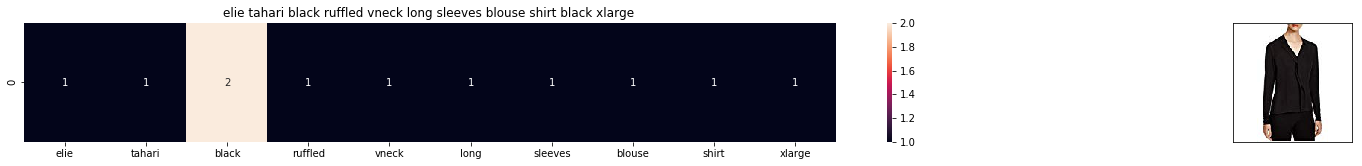

ASIN : B0728DT431
Brand: Elie Tahari
Title: elie tahari black ruffled vneck long sleeves blouse shirt black xlarge 
Euclidean similarity with the query image : 0.0


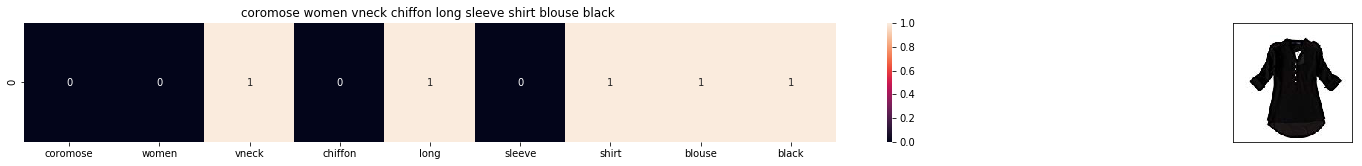

ASIN : B00NNFP22K
Brand: coromose
Title: coromose women vneck chiffon long sleeve shirt blouse black 
Euclidean similarity with the query image : 3.1622776601683795


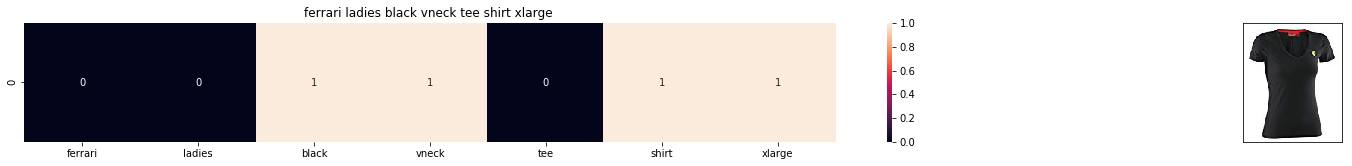

ASIN : B01EZ6XKR4
Brand: Ferrari
Title: ferrari ladies black vneck tee shirt xlarge 
Euclidean similarity with the query image : 3.1622776601683795


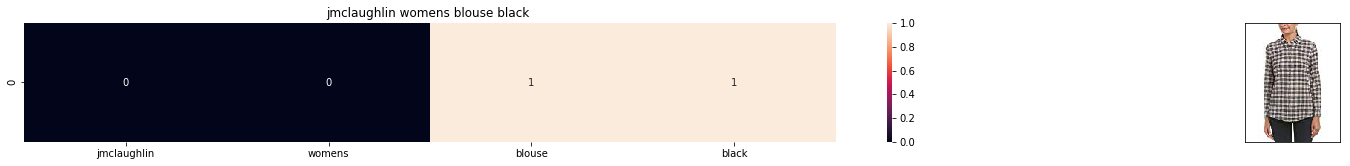

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 3.3166247903554


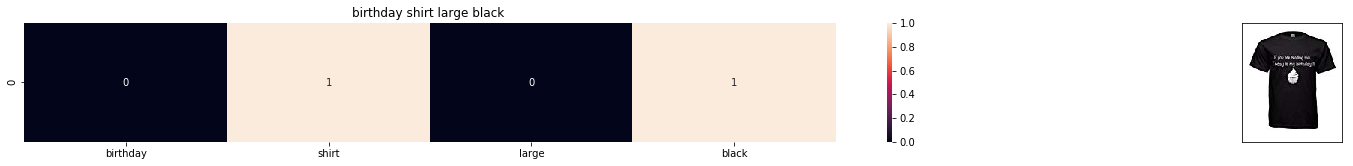

ASIN : B06XQ5V17Z
Brand: Speak Your Piece
Title: birthday shirt large black 
Euclidean similarity with the query image : 3.3166247903554


In [45]:
def bag_of_words_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

bag_of_words_model(12566, 5) 


TF-IDF based product similarity

In [46]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

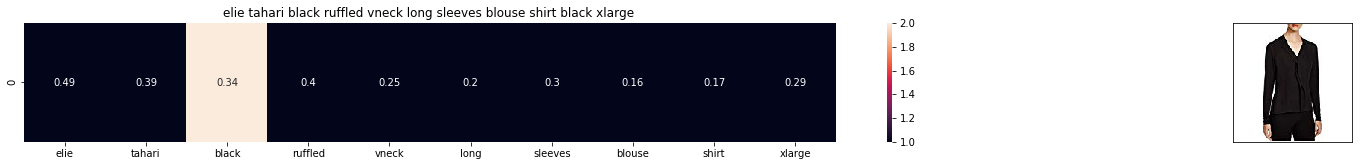

ASIN : B0728DT431
BRAND : Elie Tahari
Eucliden distance from the given image : 0.0


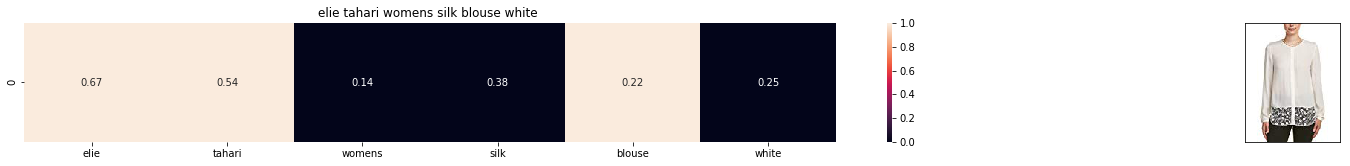

ASIN : B0758ZBV4G
BRAND : Elie Tahari
Eucliden distance from the given image : 0.930818338718771


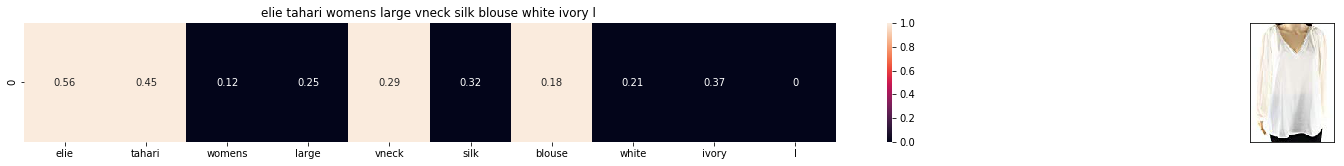

ASIN : B0758L371D
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9469671521902451


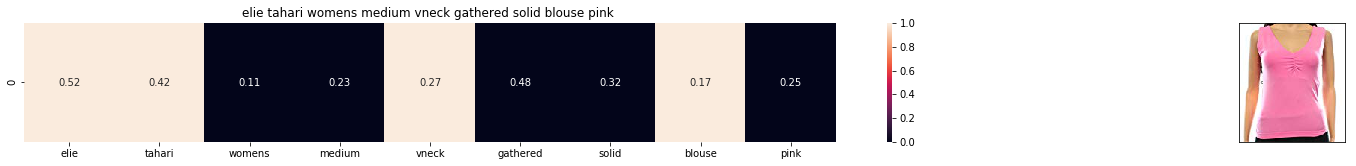

ASIN : B072VH8MKT
BRAND : Elie Tahari
Eucliden distance from the given image : 0.9917066516089337


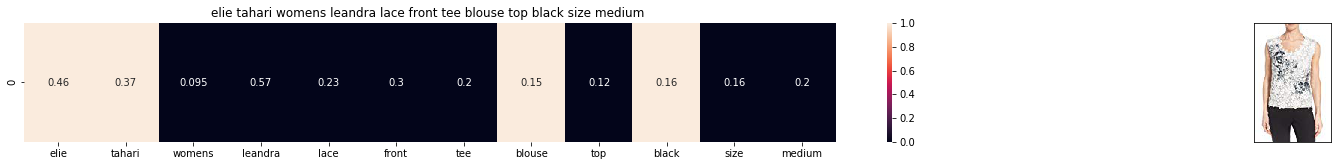

ASIN : B072HMB95W
BRAND : Elie Tahari
Eucliden distance from the given image : 1.0506076854072617


In [47]:
def tfidf_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 5)


IDF based product similarity

In [48]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [49]:
def n_containing(word):
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    return math.log(data.shape[0] / (n_containing(word)))

In [50]:
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    idf_val = idf(i)
    
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

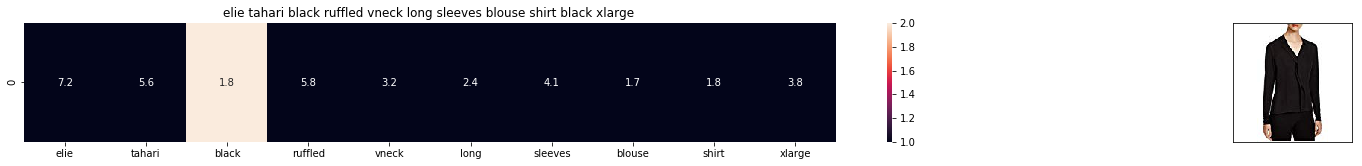

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from the given image : 0.0


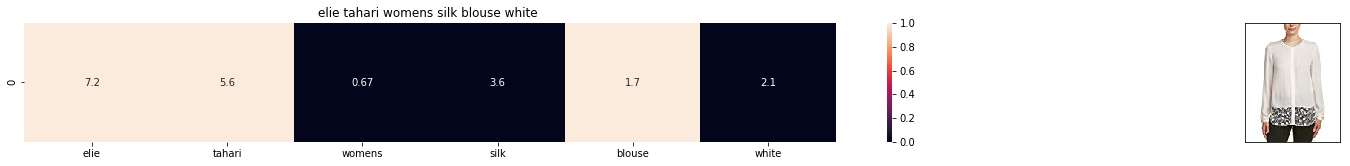

ASIN : B0758ZBV4G
Brand : Elie Tahari
euclidean distance from the given image : 10.272396151804875


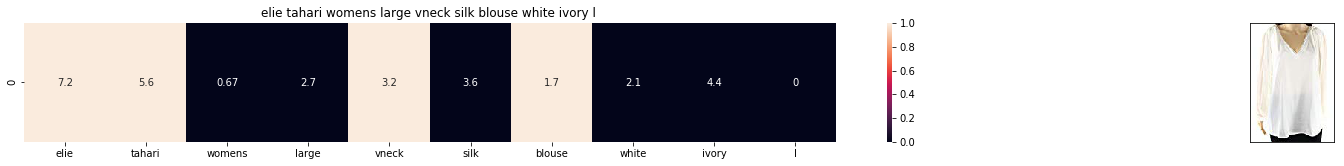

ASIN : B0758L371D
Brand : Elie Tahari
euclidean distance from the given image : 11.036534829270517


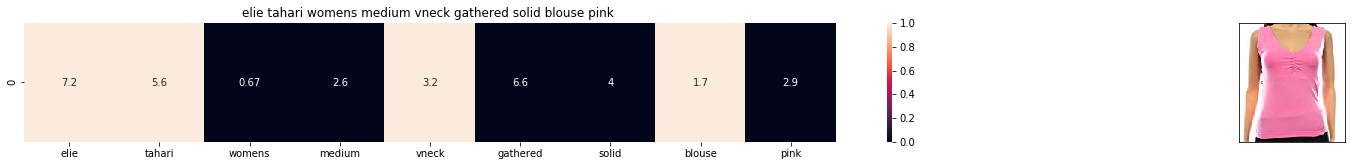

ASIN : B072VH8MKT
Brand : Elie Tahari
euclidean distance from the given image : 12.373205934247467


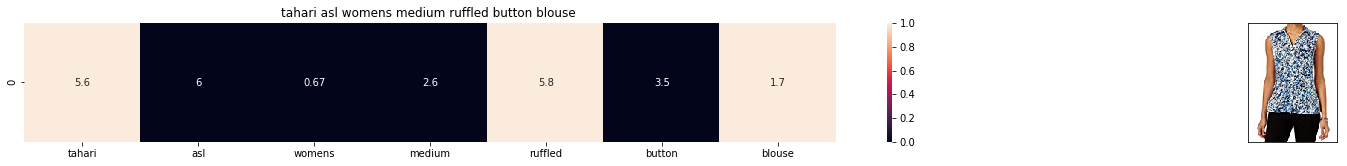

ASIN : B0727R3ZK8
Brand : Tahari ASL
euclidean distance from the given image : 12.697709298395846


In [51]:
def idf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566, 5)


Text Semantics based product similarity

In [52]:
'''from gensim.models import Word2Vec
from gensim.models import KeyedVectors'''
import pickle


'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [53]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):

    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,)))
    return  np.array(vec)

def get_distance(vec1, vec2):
    
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):

    s1_vec = get_word_vec(sentence1, doc_id1, model)

    s2_vec = get_word_vec(sentence2, doc_id2, model)

    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    ax.set_xticklabels(sentence2.split())
    ax.set_yticklabels(sentence1.split())
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [54]:
vocab = model.keys()
def build_avg_vec(sentence, num_features, doc_id, m_name):

    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    return featureVec

Average Word2Vec product similarity.

In [55]:
doc_id = 0
w2v_title = []
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

w2v_title = np.array(w2v_title)


/home/jnvamanverma/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



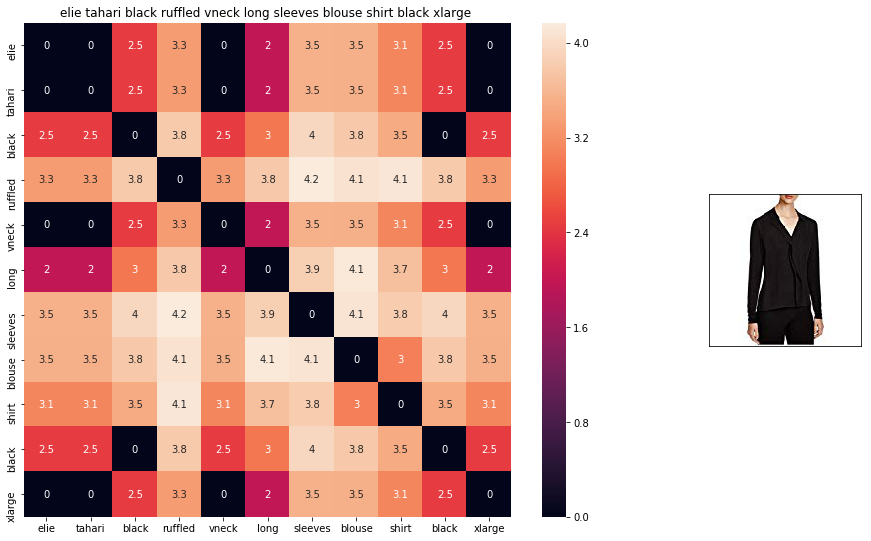

ASIN : B0728DT431
BRAND : Elie Tahari
euclidean distance from given input image : 0.0


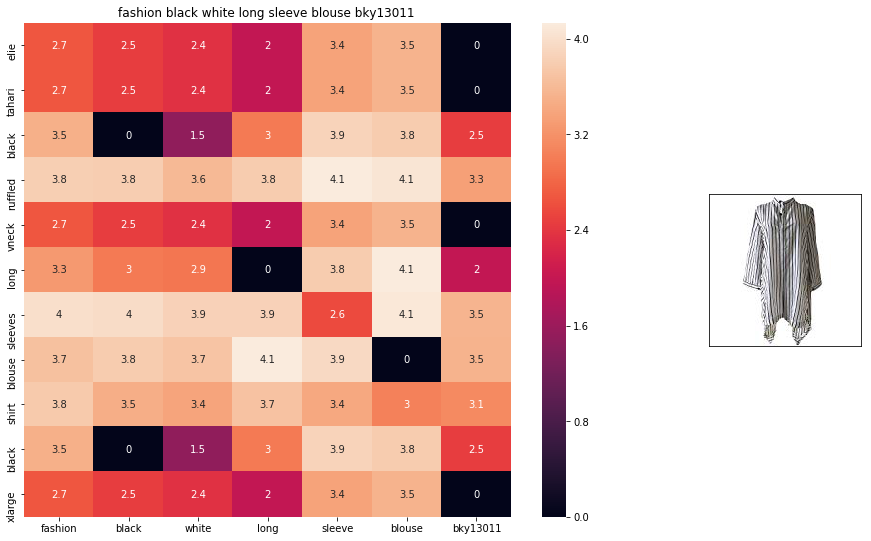

ASIN : B01FO7EI0G
BRAND : bankhunyabangyai store
euclidean distance from given input image : 0.59359264


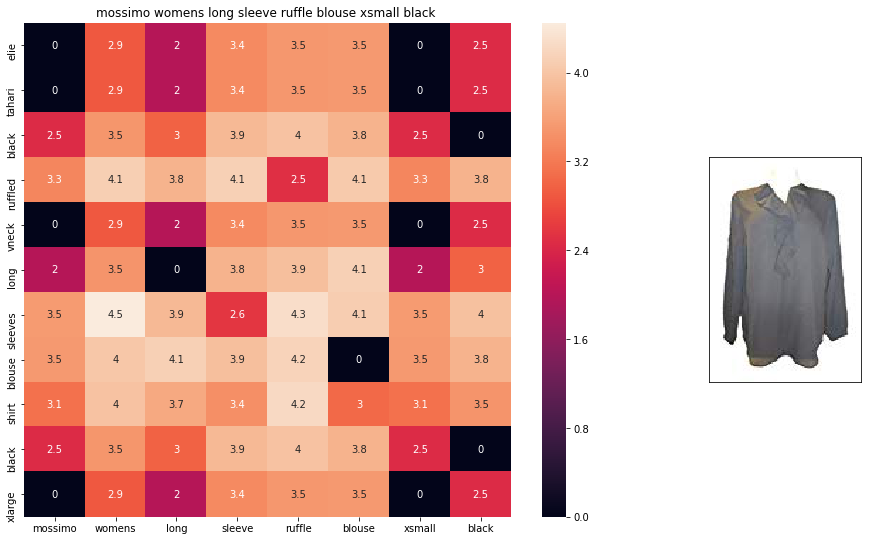

ASIN : B072BGHT28
BRAND : Mossimo
euclidean distance from given input image : 0.5938263


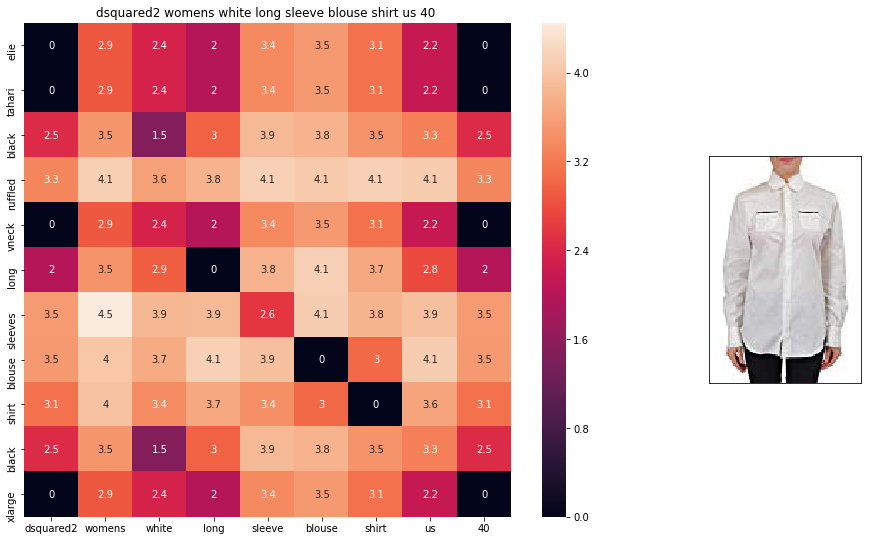

ASIN : B01758P216
BRAND : DSQUARED2
euclidean distance from given input image : 0.6099319


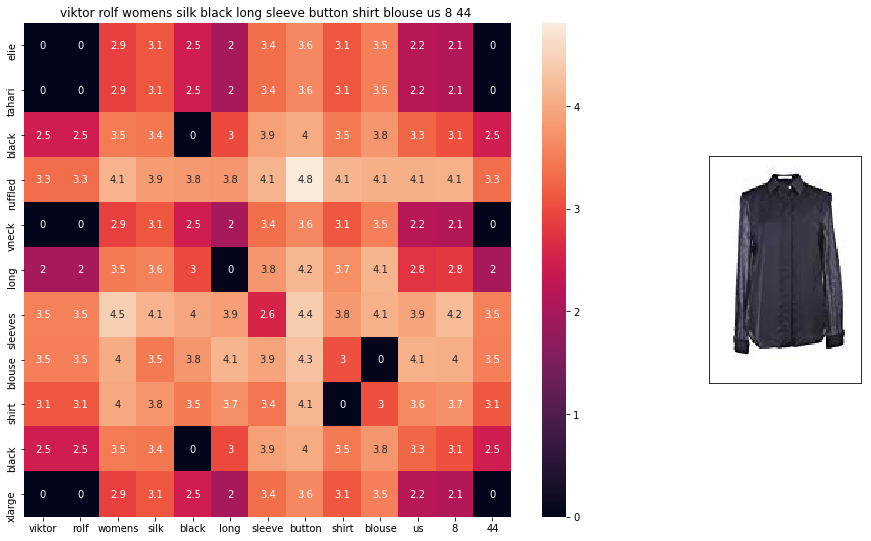

ASIN : B00N1XS6GS
BRAND : Viktor & Rolf
euclidean distance from given input image : 0.6207697


In [56]:
def avg_w2v_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 5)

IDF weighted Word2Vec for product similarity

In [57]:
doc_id = 0
w2v_title_weight = []
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
w2v_title_weight = np.array(w2v_title_weight)

/home/jnvamanverma/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



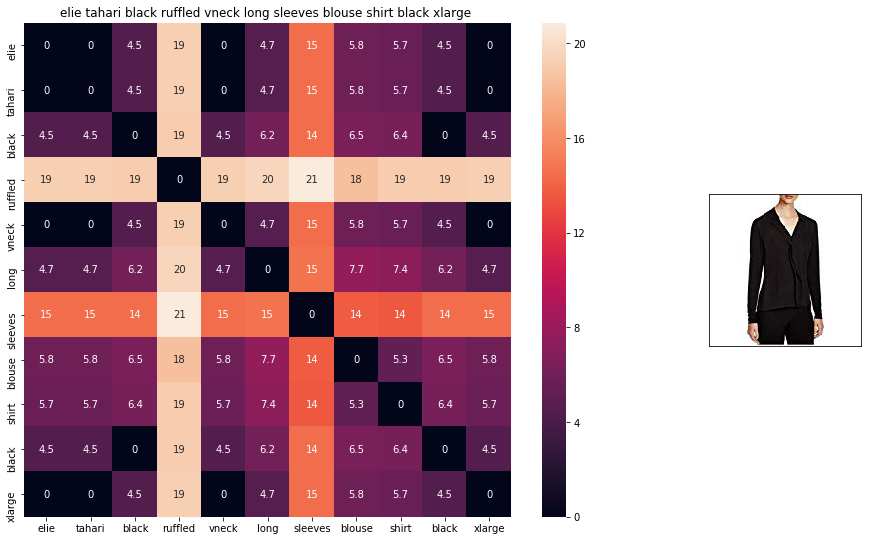

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from input : 0.0


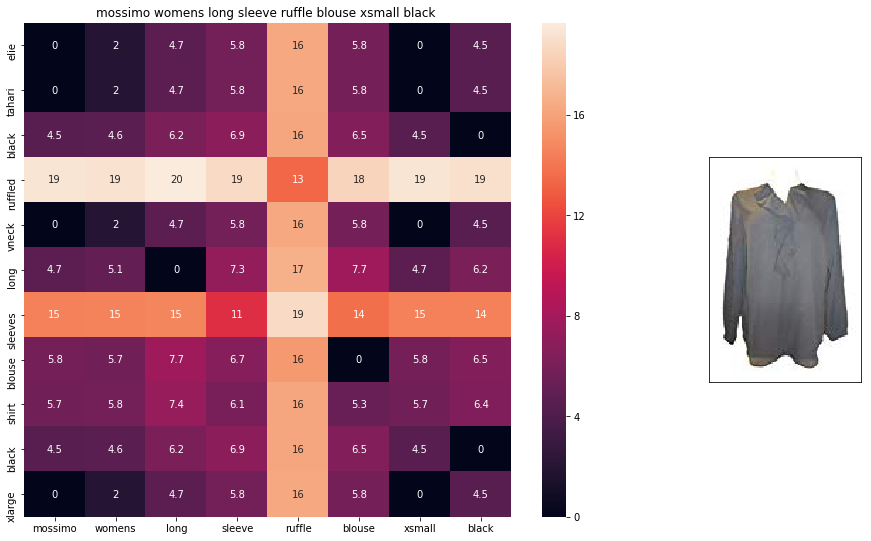

ASIN : B072BGHT28
Brand : Mossimo
euclidean distance from input : 1.817186


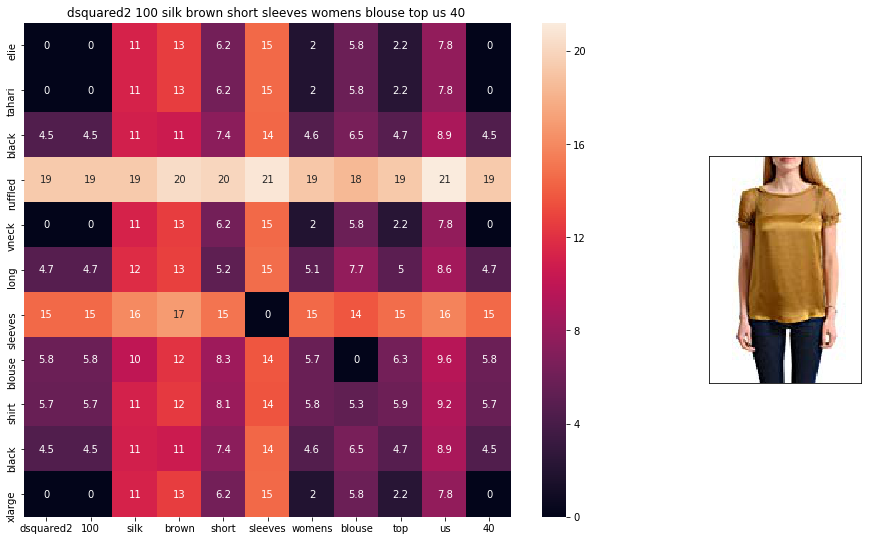

ASIN : B01D3X0DI4
Brand : DSQUARED2
euclidean distance from input : 2.1706443


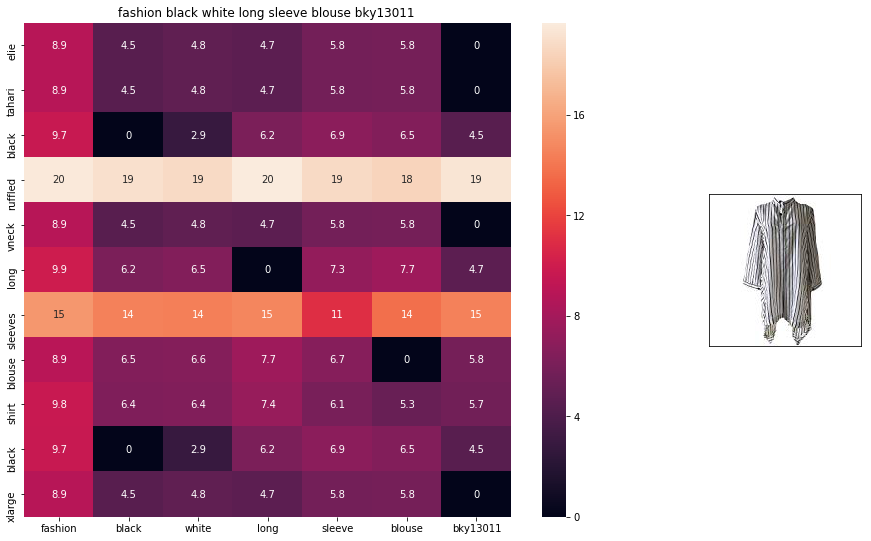

ASIN : B01FO7EI0G
Brand : bankhunyabangyai store
euclidean distance from input : 2.1719444


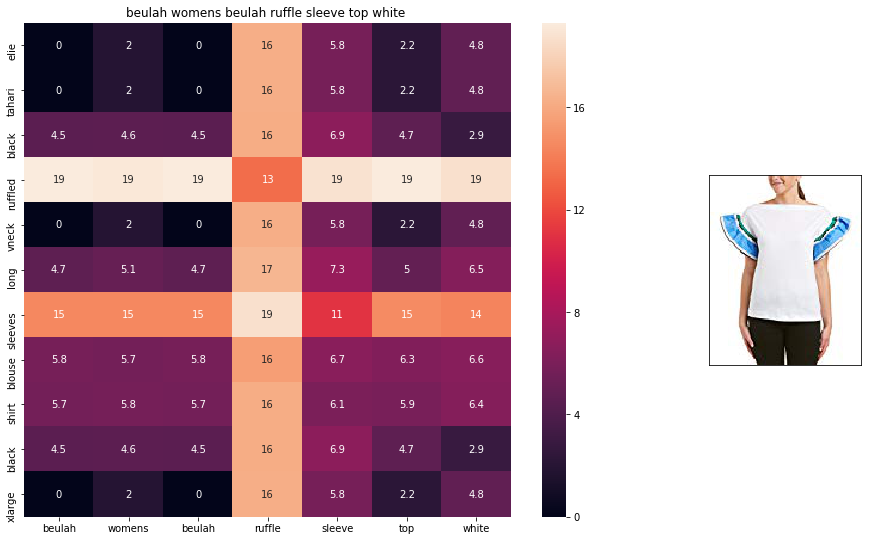

ASIN : B074DL2HQ4
Brand : Beulah
euclidean distance from input : 2.1803632


In [58]:
def weighted_w2v_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 5)


Weighted similarity using brand and color.

In [59]:
# some of the brand values are empty. 
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [60]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]],
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] 
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] 
    
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    plotly.offline.iplot(table, filename='simple_table')
    
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    ax1 = plt.subplot(gs[:, :-5])
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    ax1.set_xticklabels(sentance2.split())
    ax1.set_yticklabels(sentance1.split())
    ax1.set_title(sentance2)

    ax2 = plt.subplot(gs[:, 10:16])
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    display_img(url, ax2, fig)
    
    plt.show()

/home/jnvamanverma/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



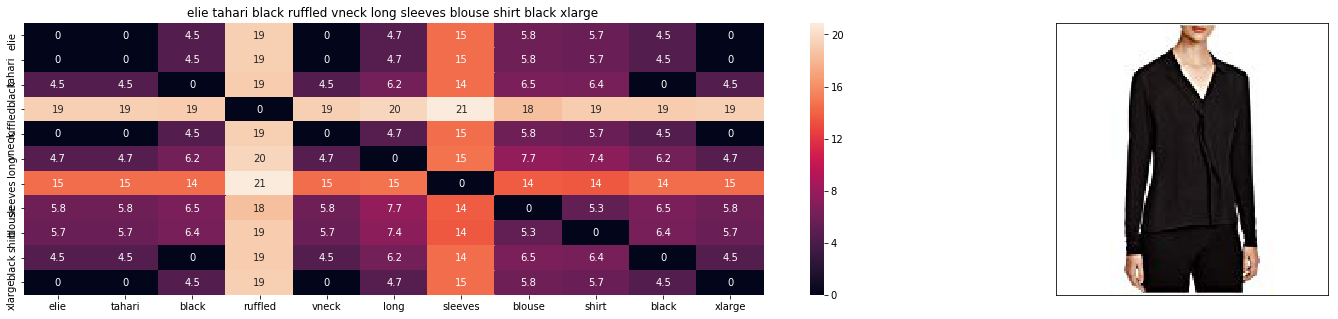

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from input : 0.0


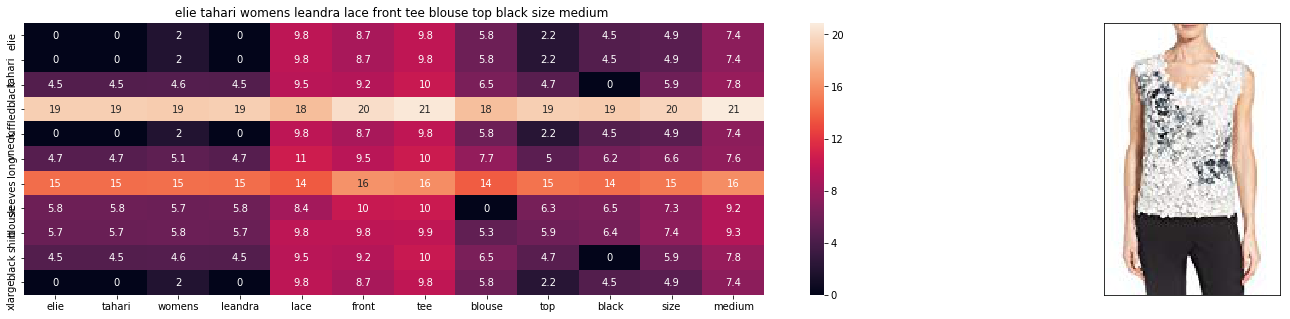

ASIN : B072HMB95W
Brand : Elie Tahari
euclidean distance from input : 1.3228859901428223


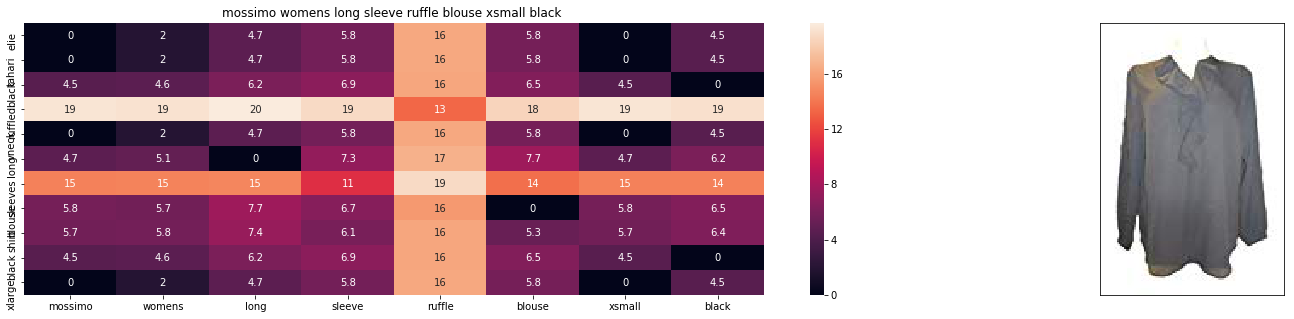

ASIN : B072BGHT28
Brand : Mossimo
euclidean distance from input : 1.7746183908449855


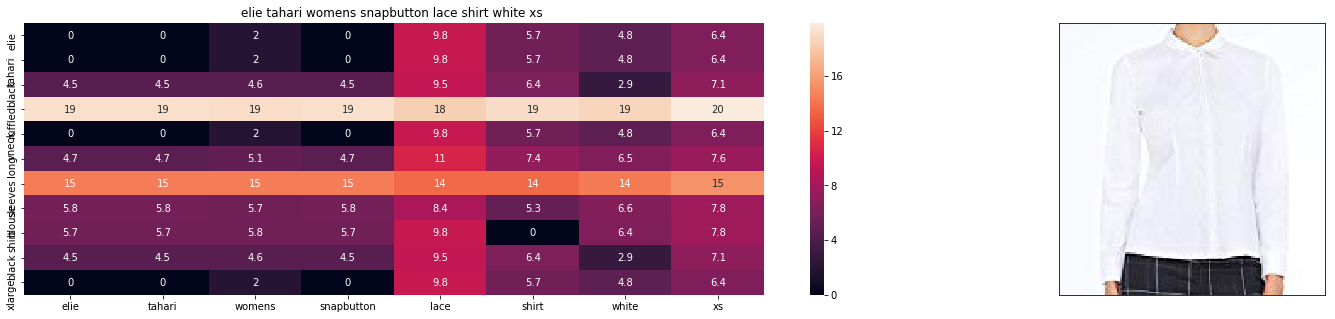

ASIN : B06X8YS632
Brand : Elie Tahari
euclidean distance from input : 1.9286864282507565


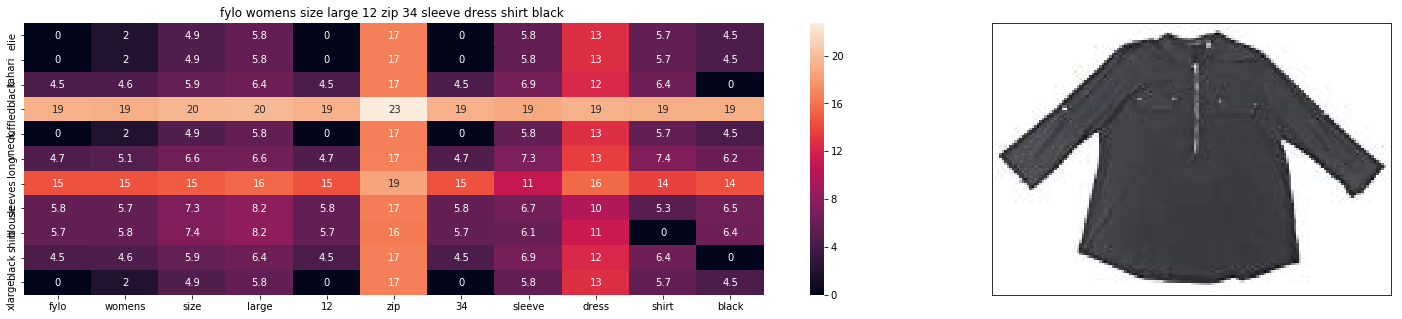

ASIN : B0718Y9J4M
Brand : f
euclidean distance from input : 1.9635807992834713


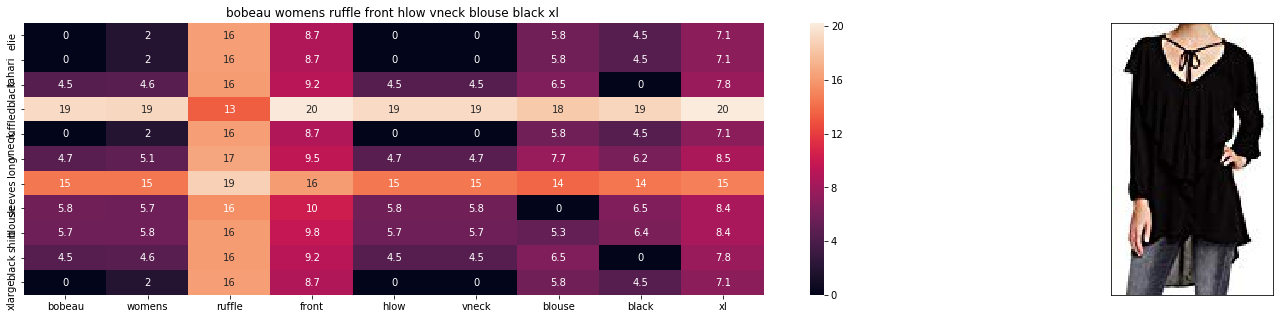

ASIN : B0758J19PY
Brand : Bobeau
euclidean distance from input : 2.017448953436538


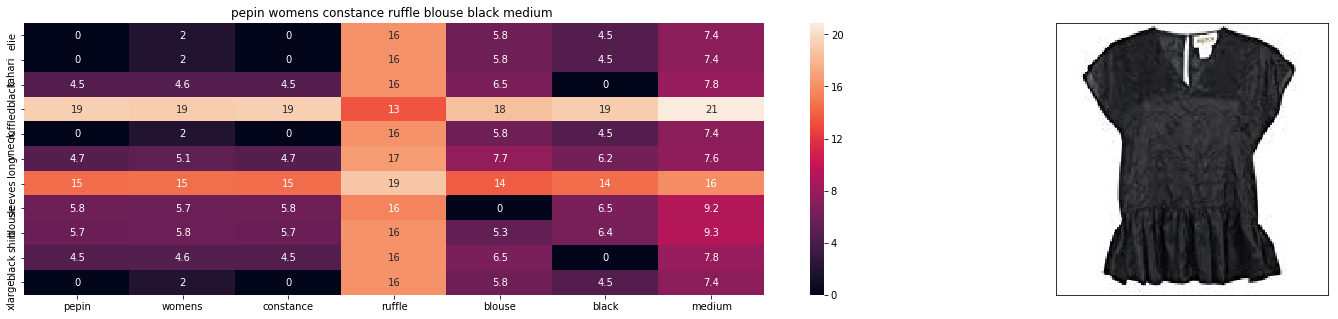

ASIN : B01N5VOV3H
Brand : Pepin
euclidean distance from input : 2.0543058908449856


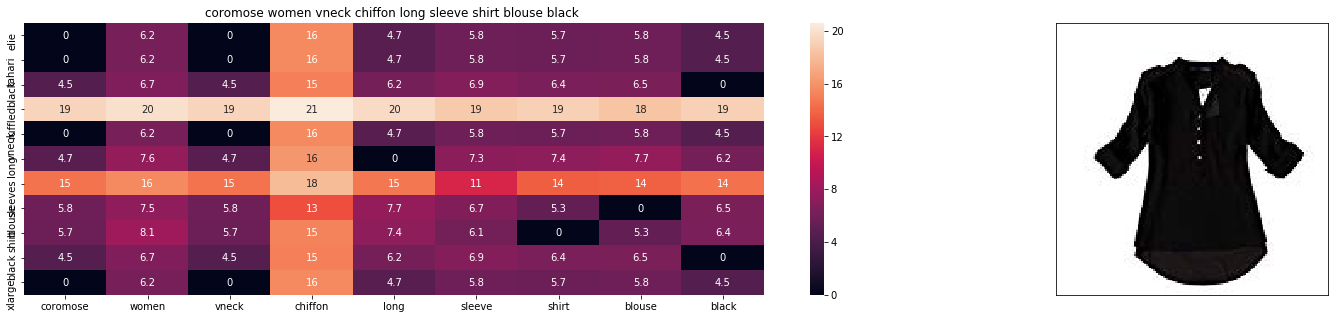

ASIN : B00NNFP22K
Brand : coromose
euclidean distance from input : 2.0553211725222313


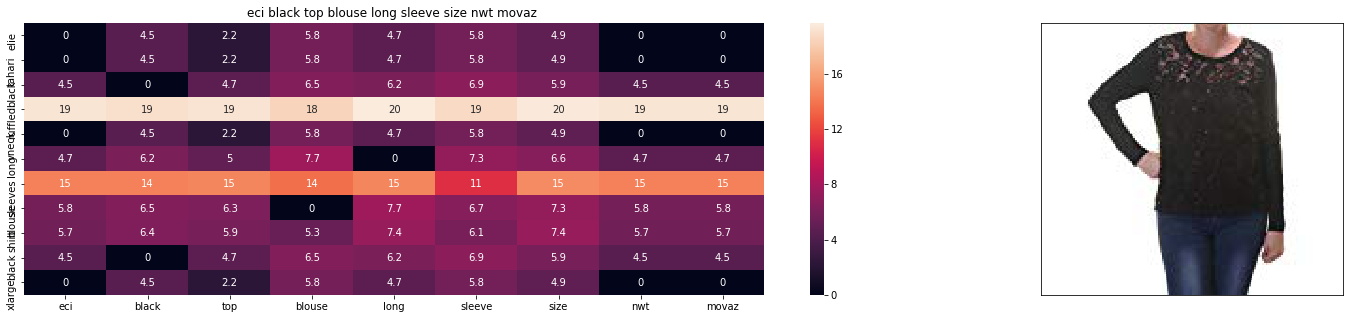

ASIN : B014LAZII8
Brand : ECI
euclidean distance from input : 2.059850934790298


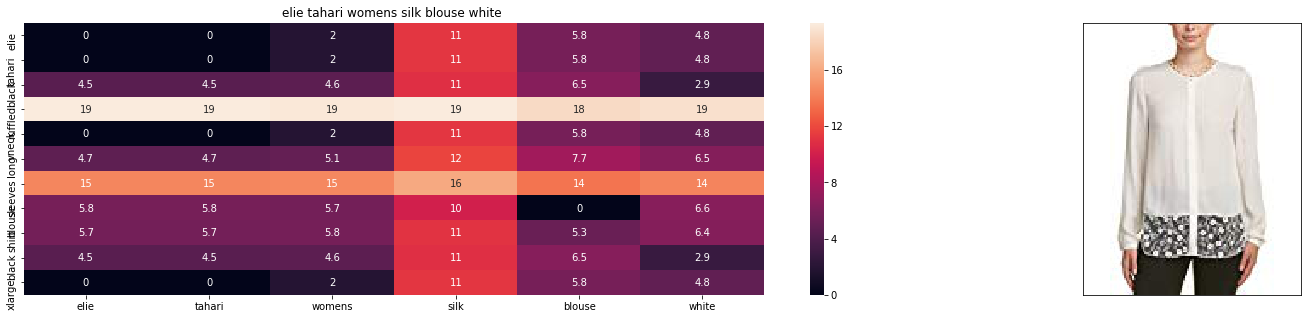

ASIN : B0758ZBV4G
Brand : Elie Tahari
euclidean distance from input : 2.063144874753442


In [61]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 10)
# in the give heat map, each cell contains the euclidean distance between words i, j

/home/jnvamanverma/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning:

invalid value encountered in sqrt



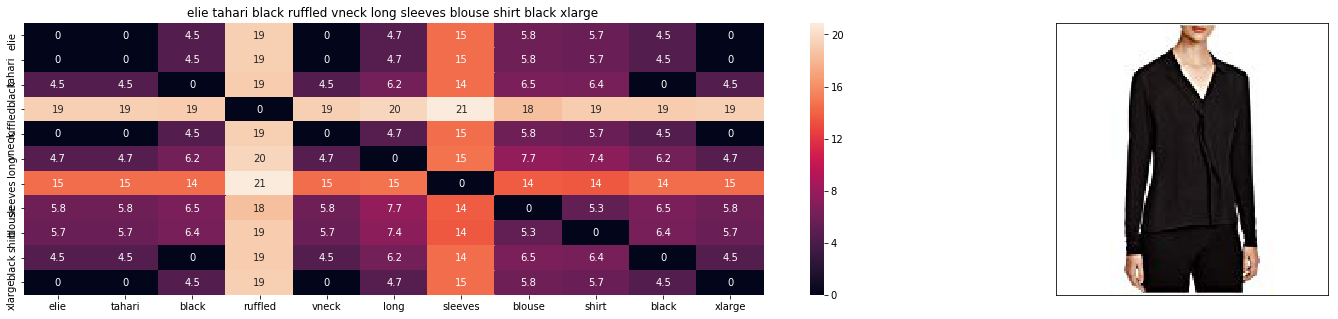

ASIN : B0728DT431
Brand : Elie Tahari
euclidean distance from input : 0.0


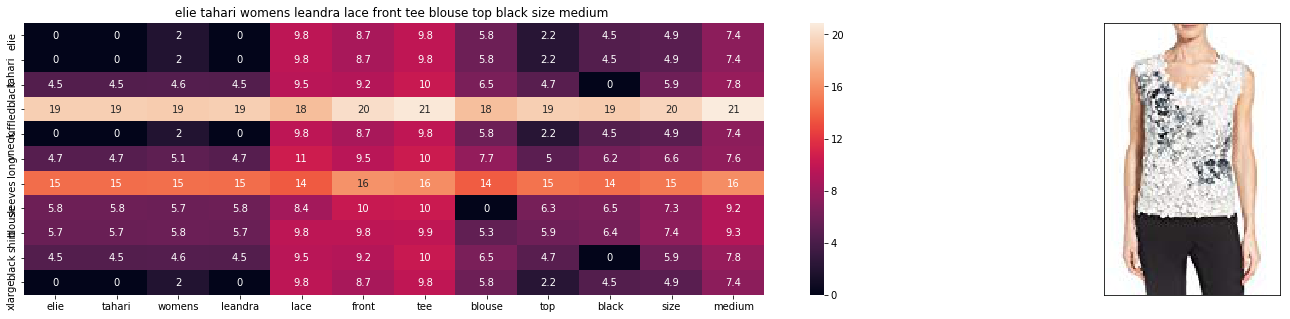

ASIN : B072HMB95W
Brand : Elie Tahari
euclidean distance from input : 0.24052472548051315


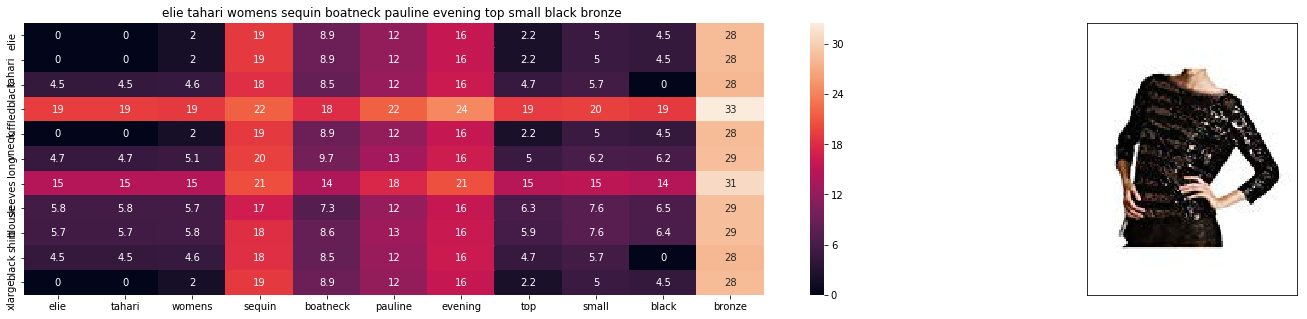

ASIN : B005E2L4XG
Brand : Elie Tahari
euclidean distance from input : 0.39617441350763494


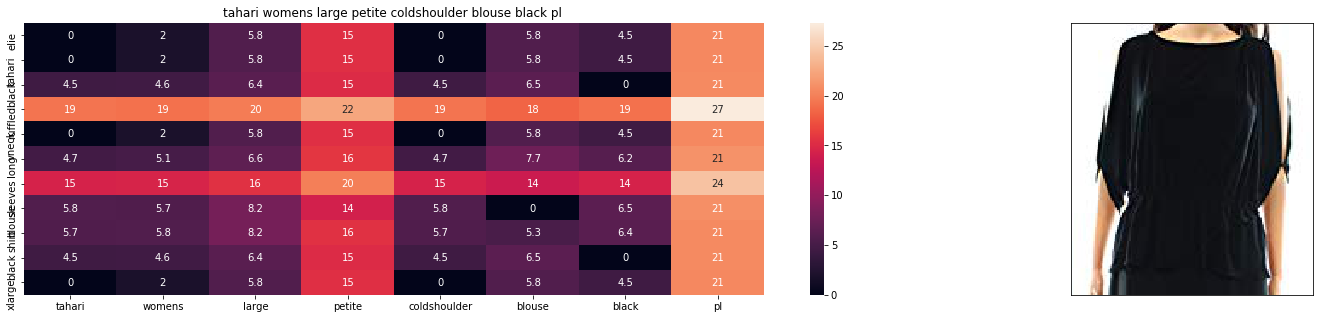

ASIN : B0714JZFLY
Brand : T Tahari
euclidean distance from input : 1.2751026153564453


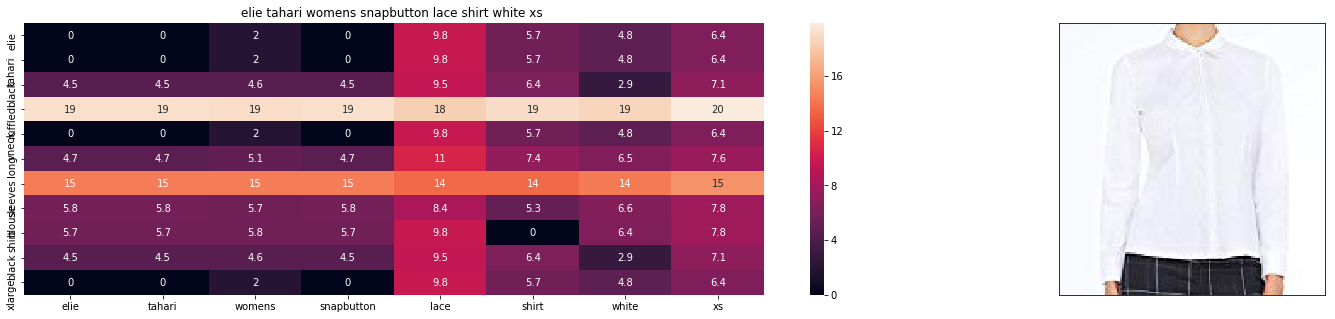

ASIN : B06X8YS632
Brand : Elie Tahari
euclidean distance from input : 1.5077540834417609


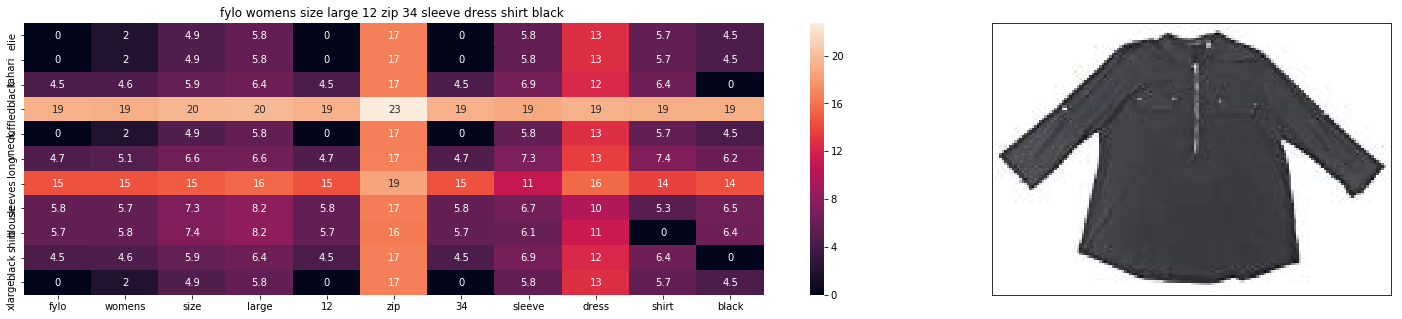

ASIN : B0718Y9J4M
Brand : f
euclidean distance from input : 1.514098514538618


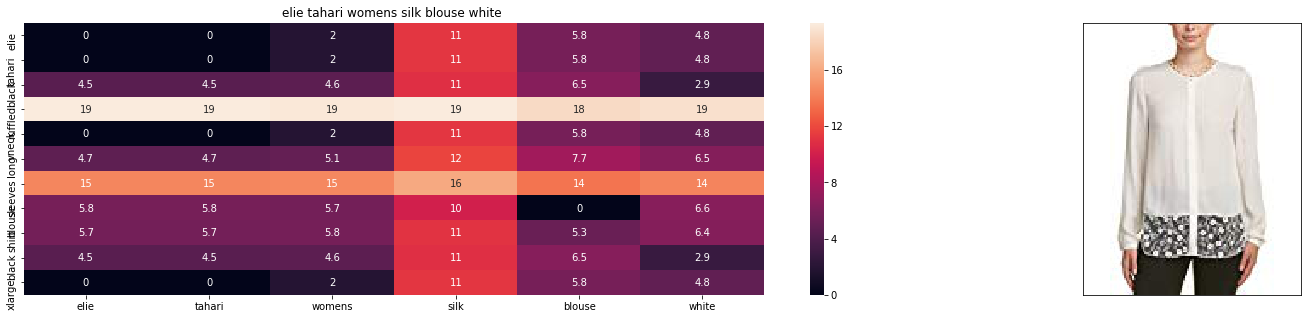

ASIN : B0758ZBV4G
Brand : Elie Tahari
euclidean distance from input : 1.5322010737149763


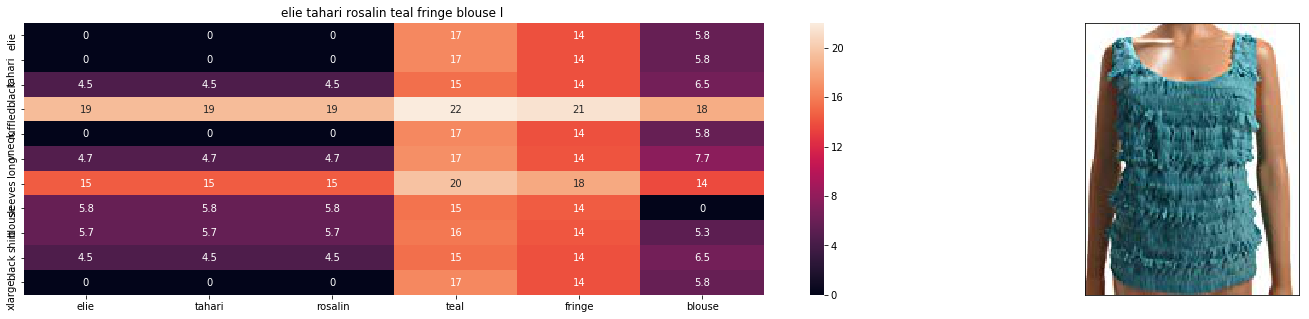

ASIN : B0751J7MJ5
Brand : Elie Tahari
euclidean distance from input : 1.5829137285223271


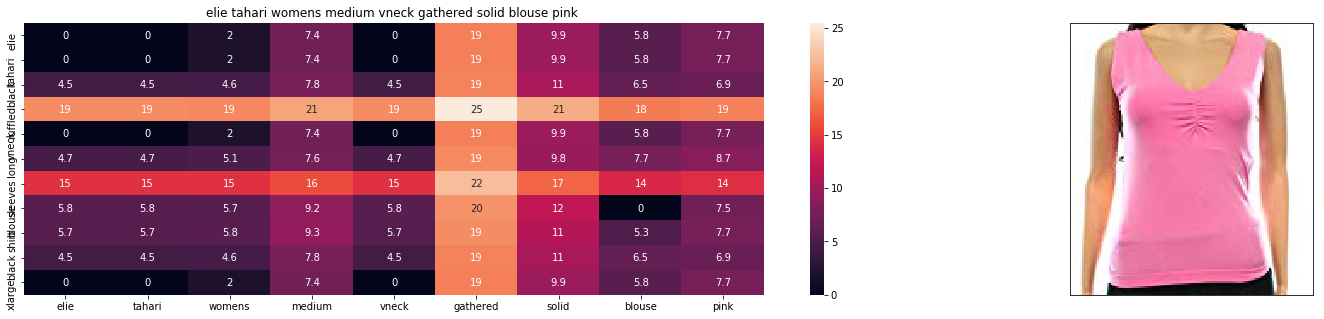

ASIN : B072VH8MKT
Brand : Elie Tahari
euclidean distance from input : 1.594001562273659


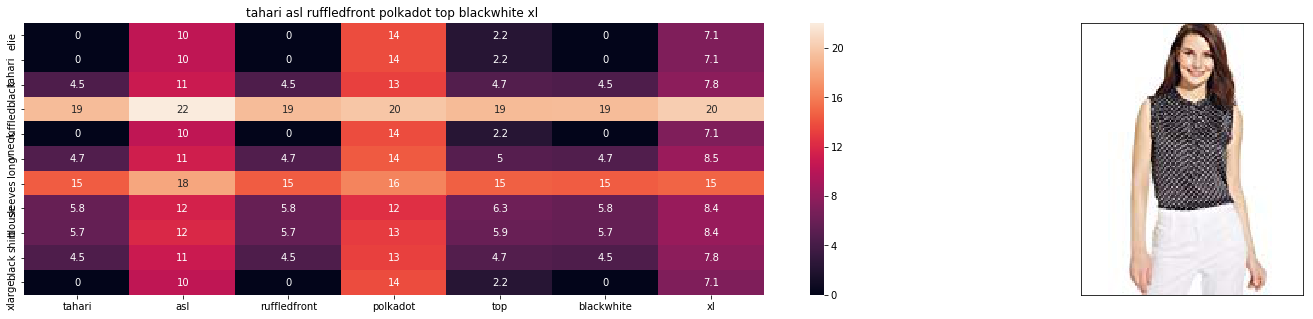

ASIN : B074MZTZS5
Brand : Tahari ASL
euclidean distance from input : 1.609147817766823


In [62]:
# brand and color weight =50
# title vector weight = 5

idf_w2v_brand(12566, 5, 50, 10)